# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Need to find the dataset features that correlate with price increasing (or decreasing) the most. To accomplish this, we need to find data (already done) with sufficient features to build a useful model. "Business Understanding" in this case is very straightforward, so proceed to "Data Understanding".

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. First load the data, then check `.info()`, `.head()`/`.tail()`, and `.value_counts()` to get a general idea.
1. Remove columns with meaningless data (mainly IDs). Be careful here, because your idea of "meaningless" may be different from what a good model considers "meaningless".
1. Remove columns with many NaNs.
1. See if there are any columns where strings could be meaningfully converted into numbers using ordinal encoding or one-hot encoding.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

import random

In [2]:
cars_df_original = pd.read_csv('data/vehicles.csv')
cars_df_original.info()
cars_df_original.iloc[30:40]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
30,7316743432,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,NaN,NaN,pickup,red,al
31,7316356412,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,NaN,rwd,full-size,truck,black,al
32,7316343444,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,1GT220CG8CZ231238,4wd,NaN,pickup,black,al
33,7316304717,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,al
34,7316285779,auburn,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,NaN,4wd,NaN,truck,grey,al
35,7316257769,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,clean,other,1GCHTCE37G1186784,4wd,NaN,pickup,red,al
36,7316133914,auburn,38590,2011.0,chevrolet,corvette grand sport,good,8 cylinders,gas,30237.0,clean,other,1G1YR3DW3B5102190,rwd,NaN,other,red,al
37,7316130053,auburn,4500,1992.0,jeep,cherokee,excellent,6 cylinders,gas,192000.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
38,7315816316,auburn,32990,2017.0,jeep,wrangler unlimited sport,good,6 cylinders,gas,30041.0,clean,other,1C4BJWDG5HL705371,4wd,NaN,other,silver,al
39,7315770394,auburn,24590,2017.0,chevrolet,silverado 1500 regular,good,6 cylinders,gas,40784.0,clean,other,1GCNCNEH7HZ118773,NaN,NaN,pickup,white,al


In [3]:
# pd.set_option("display.max_rows", None)
# print(cars_df_original["region"].value_counts(dropna=False))
# print(cars_df_original["price"].value_counts(dropna=False))
# print(cars_df_original["year"].value_counts(dropna=False))
# print(cars_df_original["condition"].value_counts(dropna=False))
# print(cars_df_original["cylinders"].value_counts(dropna=False))
# print(cars_df_original["fuel"].value_counts(dropna=False))
# print(cars_df_original["odometer"].value_counts(dropna=False))
# print(cars_df_original["title_status"].value_counts(dropna=False))
# print(cars_df_original["transmission"].value_counts(dropna=False))
# print(cars_df_original["drive"].value_counts(dropna=False))
# print(cars_df_original["size"].value_counts(dropna=False))
# print(cars_df_original["type"].value_counts(dropna=False))
# print(cars_df_original["paint_color"].value_counts(dropna=False))
# print(cars_df_original["manufacturer"].value_counts(dropna=False))
# print(cars_df_original["state"].value_counts(dropna=False))
# print(cars_df_original.query("condition.isna() and price == 0"))

In [4]:
# Irrelevant data:
cars_df_cleaned = cars_df_original.drop(["id", "VIN"], axis = 1)
cars_df_cleaned = cars_df_cleaned.drop(["model"], axis = 1) # too many unique values
# Drop columns with too much NaN:
cars_df_cleaned = cars_df_cleaned.drop(["size"], axis = 1)
# Drop rows with some NaN:
cars_df_cleaned = cars_df_cleaned.dropna(subset=["year", "odometer"])
# Convert data types (required dropping NaN):
cars_df_cleaned["year"] = cars_df_cleaned["year"].astype("int")
cars_df_cleaned["odometer"] = cars_df_cleaned["odometer"].astype("int")

# Drop columns that probably have too much NaN (but a better data scientist could probably work with):
cars_df_cleaned = cars_df_cleaned.drop(["cylinders", "paint_color"], axis = 1)
# Convert some NaNs to "unknown" (for use in one-hot encoding):
cars_df_cleaned = cars_df_cleaned.fillna({
    "condition": "unknown",
    "fuel":      "unknown",
    "drive":     "unknown",
    "type":      "unknown",
})
# Convert some values into a binary value (for use in one-hot encoding):
cars_df_cleaned["title_status"] = cars_df_cleaned["title_status"].apply(lambda x: "not clean" if x != "clean" else x)
cars_df_cleaned["transmission"] = cars_df_cleaned["transmission"].apply(lambda x: "not automatic" if x != "automatic" else x)

# Group together rare fuel types because there's not very many:
cars_df_cleaned["fuel"] = cars_df_cleaned["fuel"].apply(lambda x: "other" if x in ["hybrid", "unknown", "electric"] else x)
# Change "year" to "years_since_1900" because there aren't any cars older than that:
cars_df_cleaned["year"] = cars_df_cleaned["year"].apply(lambda x: x - 1900)
cars_df_cleaned.rename(columns={"year": "years_since_1900"}, inplace=True)
# Save a little bit of memory (and slightly speed up execution, hopefully):
cars_df_cleaned["years_since_1900"] = cars_df_cleaned["years_since_1900"].astype("int32")

cars_df_cleaned.info()
cars_df_cleaned.tail(10)

<class 'pandas.core.frame.DataFrame'>
Index: 421344 entries, 27 to 426879
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   region            421344 non-null  object
 1   price             421344 non-null  int64 
 2   years_since_1900  421344 non-null  int32 
 3   manufacturer      405077 non-null  object
 4   condition         421344 non-null  object
 5   fuel              421344 non-null  object
 6   odometer          421344 non-null  int64 
 7   title_status      421344 non-null  object
 8   transmission      421344 non-null  object
 9   drive             421344 non-null  object
 10  type              421344 non-null  object
 11  state             421344 non-null  object
dtypes: int32(1), int64(2), object(9)
memory usage: 40.2+ MB


,region,price,years_since_1900,manufacturer,condition,fuel,odometer,title_status,transmission,drive,type,state
426870,wyoming,22990,120,hyundai,good,gas,3066,clean,not automatic,fwd,sedan,wy
426871,wyoming,17990,118,kia,good,gas,34239,clean,not automatic,unknown,SUV,wy
426872,wyoming,32590,120,mercedes-benz,good,gas,19059,clean,not automatic,rwd,sedan,wy
426873,wyoming,30990,118,mercedes-benz,good,gas,15080,clean,automatic,rwd,other,wy
426874,wyoming,33590,118,lexus,good,gas,30814,clean,automatic,rwd,sedan,wy
426875,wyoming,23590,119,nissan,good,gas,32226,clean,not automatic,fwd,sedan,wy
426876,wyoming,30590,120,volvo,good,gas,12029,clean,not automatic,fwd,sedan,wy
426877,wyoming,34990,120,cadillac,good,diesel,4174,clean,not automatic,unknown,hatchback,wy
426878,wyoming,28990,118,lexus,good,gas,30112,clean,not automatic,fwd,sedan,wy
426879,wyoming,30590,119,bmw,good,gas,22716,clean,not automatic,rwd,coupe,wy


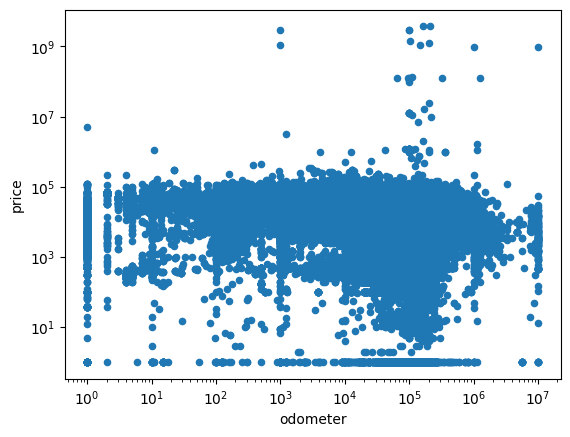

In [5]:
cars_df_cleaned.plot(kind="scatter", y="price", x="odometer", logy=True, logx=True)
plt.savefig("images/price_odometer_unclean.png")

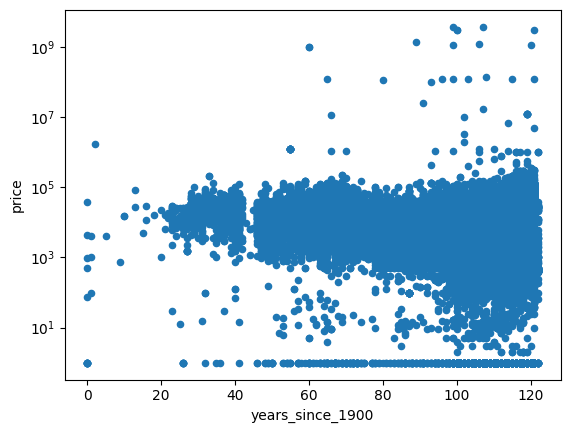

In [6]:
cars_df_cleaned.plot(kind="scatter", y="price", x="years_since_1900", logy=True, logx=False)
plt.savefig("images/price_years_unclean.png")

In [7]:
# Clearly a used car dealership is not selling cars valued >$1M
cars_df_cleaned = cars_df_cleaned.query("price < 1E6")
# Cars older than 1920 are probably not useful for determining the rest of the cars
cars_df_cleaned = cars_df_cleaned.query("years_since_1900 >= 20")

In [8]:
# Probably useful, but too many unique values, so just drop for now:
cars_df_prepared = cars_df_cleaned.drop(["manufacturer", "state", "region"], axis = 1)
cars_df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421259 entries, 27 to 426879
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             421259 non-null  int64 
 1   years_since_1900  421259 non-null  int32 
 2   condition         421259 non-null  object
 3   fuel              421259 non-null  object
 4   odometer          421259 non-null  int64 
 5   title_status      421259 non-null  object
 6   transmission      421259 non-null  object
 7   drive             421259 non-null  object
 8   type              421259 non-null  object
dtypes: int32(1), int64(2), object(6)
memory usage: 30.5+ MB


In [9]:
# One-hot encoding:
cars_df_prepared = pd.concat([cars_df_prepared, pd.get_dummies(cars_df_prepared[["drive", "type", "title_status", "transmission", "condition", "fuel"]])], axis=1).drop(["drive", "type", "title_status", "transmission", "condition", "fuel"], axis=1)
# axis=1 on pd.concat is needed to keep the datatypes the same

In [10]:
# Drop "unknown" or error prices (<$100), but save them as a test set (not used though):
cars_df_unknowns = cars_df_prepared.query("price < 1E2") # ~8%
cars_df          = cars_df_prepared.query("price >= 1E2")
cars_df_unknowns.reset_index(drop=True, inplace=True)
cars_df.reset_index(drop=True, inplace=True)

# Split into train and test set:
cars_df_train_X, cars_df_dev_X, cars_df_train_y, cars_df_dev_y, cars_df_train_idx, cars_df_dev_idx = \
    train_test_split(cars_df.drop(["price"], axis=1), cars_df["price"], np.arange(len(cars_df)), test_size = 0.15, random_state = 123)

#old version:
# random.seed(123)
# for _ in range(int(cars_df.shape[0] * .15)):
#     pop_idx = random.randrange(len(cars_df_train_idx))
#     cars_df_dev_idx.append(cars_df_train_idx[pop_idx])
#     cars_df_train_idx.pop(pop_idx)
# print(len(cars_df_train_idx), len(cars_df_dev_idx))
# print(set(cars_df_train_idx) & set(cars_df_dev_idx))
# cars_df_train = cars_df.iloc[cars_df_train_idx]
# cars_df_dev = cars_df.iloc[cars_df_dev_idx]

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [11]:
# Simple model with only the numerical values just to experiment:

lr = LinearRegression(fit_intercept=True).fit(cars_df_train_X[["years_since_1900", "odometer"]], cars_df_train_y)

preds_train = lr.predict(cars_df_train_X[["years_since_1900", "odometer"]])
preds_dev   = lr.predict(cars_df_dev_X[["years_since_1900", "odometer"]])

print(mean_squared_error(cars_df_train_y, preds_train))
print(mean_squared_error(cars_df_dev_y, preds_dev))

213124852.7218251
234707077.3668031


In [12]:
selectors = []
Xt_list = []

for i in range(1, 13):
    selectors.append(SequentialFeatureSelector(estimator=LinearRegression(),
                     n_features_to_select=i,
                     scoring = 'neg_mean_squared_error',
                     cv = [[cars_df_train_idx, cars_df_dev_idx]]))
    Xt_list.append(selectors[-1].fit_transform(cars_df.drop(["price"], axis=1), cars_df["price"]))

In [13]:
for s in selectors:
    print(s.get_feature_names_out())

['years_since_1900']
['years_since_1900' 'drive_fwd']
['years_since_1900' 'drive_fwd' 'fuel_gas']
['years_since_1900' 'drive_fwd' 'transmission_automatic' 'fuel_gas']
['years_since_1900' 'drive_fwd' 'drive_unknown' 'transmission_automatic'
 'fuel_gas']
['years_since_1900' 'drive_fwd' 'drive_unknown' 'transmission_automatic'
 'fuel_diesel' 'fuel_gas']
['years_since_1900' 'odometer' 'drive_fwd' 'drive_unknown'
 'transmission_automatic' 'fuel_diesel' 'fuel_gas']
['years_since_1900' 'odometer' 'drive_fwd' 'drive_unknown'
 'transmission_automatic' 'condition_unknown' 'fuel_diesel' 'fuel_gas']
['years_since_1900' 'odometer' 'drive_fwd' 'drive_unknown' 'type_pickup'
 'transmission_automatic' 'condition_unknown' 'fuel_diesel' 'fuel_gas']
['years_since_1900' 'odometer' 'drive_fwd' 'drive_unknown' 'type_pickup'
 'type_truck' 'transmission_automatic' 'condition_unknown' 'fuel_diesel'
 'fuel_gas']
['years_since_1900' 'odometer' 'drive_fwd' 'drive_unknown' 'type_other'
 'type_pickup' 'type_truck' '

In [14]:
mse_list = []
for Xt in Xt_list:
    lr = LinearRegression().fit(Xt, cars_df["price"])
    model_preds = lr.predict(Xt)
    mse = mean_squared_error(cars_df["price"], model_preds)
    mse_list.append(mse)

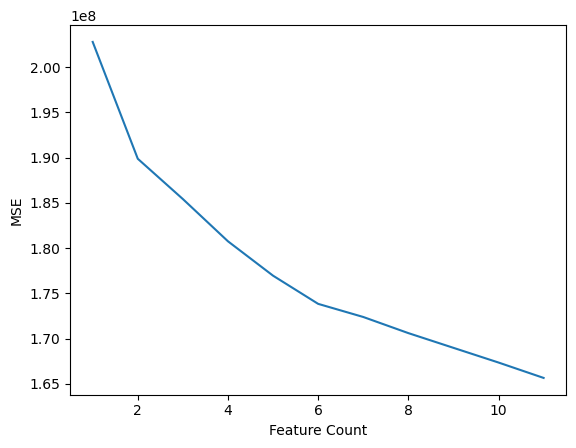

In [15]:
mse_df = pd.Series(mse_list).reindex(range(1, len(mse_list)+1))
mse_df.plot(kind="line")
plt.xlabel("Feature Count")
plt.ylabel("MSE")
plt.savefig("images/SequentialFeatureSelector.png")
plt.show()

In [16]:
scaled_ridge_model = Pipeline([
    ("scale", StandardScaler()),
    ("regression", Ridge()),
])
alpha_tries = {"regression__alpha": 10**np.linspace(-4, 5, 100)}
model_finder = GridSearchCV(estimator = scaled_ridge_model,
                            param_grid = alpha_tries,
                            scoring = "neg_mean_squared_error",
                            cv = 10)
# Using cv=[[cars_df_train_idx, cars_df_dev_idx]] results in alpha converging to 0 which is not useful

In [17]:
model_finder.fit(cars_df.drop(["price"], axis=1), cars_df["price"])
best_model = model_finder.best_estimator_

In [18]:
best_model.named_steps["regression"].alpha

np.float64(1519.9110829529332)

In [19]:
pd.DataFrame({
    "Feature": cars_df.drop(["price"], axis=1).columns,
    "Coefficient": best_model.named_steps["regression"].coef_,
    "Coefficient_abs": np.abs(best_model.named_steps["regression"].coef_),
}).sort_values(by="Coefficient_abs", ascending=False)
# Front-wheel drive is bad?!

,Feature,Coefficient,Coefficient_abs
0,years_since_1900,4524.444139,4524.444139
31,fuel_diesel,2231.301200,2231.301200
3,drive_fwd,-1971.013608,1971.013608
1,odometer,-1641.870747,1641.870747
32,fuel_gas,-1514.887820,1514.887820
2,drive_4wd,1458.056786,1458.056786
14,type_pickup,1372.696306,1372.696306
23,transmission_not automatic,1236.975578,1236.975578
22,transmission_automatic,-1236.975578,1236.975578
16,type_truck,1156.775712,1156.775712


In [20]:
scaled_lasso_model = Pipeline([
    ("scale", StandardScaler()),
    ("regression", Lasso()),
])
model_finder = GridSearchCV(estimator = scaled_lasso_model,
                            param_grid = alpha_tries,
                            scoring = "neg_mean_squared_error",
                            cv = 10)

In [21]:
# model_finder.fit(cars_df.drop(["price"], axis=1), cars_df["price"])
# best_model = model_finder.best_estimator_
# best_model.named_steps["regression"].alpha

# Took too long

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

The models are good. There should be a separate model for trucks compared to normal cars, however I don't know all the qualifications a "normal car" has, and I've run out of time.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Combining the results of SequentialFeatureSelector and GridSearchCV with Ridge regression, a used car dealership should focus on trucks. However, while those have high prices, the volume is much lower than regular cars (given this dataset, and my general observations of the real-world market). Other than that, newer cars with low mileage (odometer values), "fair" condition, and manual transmission will maximize price.